# Priority Queues and Heaps

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/chapters/heap.ipynb)

## The `heapq` module

The `heapq` module provides functions for adding and removing elements to and from a heap.



In [1]:
from heapq import heappush, heappop

The heap itself is literally a list, so if you create an empty list, you can think of it as a heap with no elements.

In [2]:
heap = []

Then you can use `heappush` to add one element at a time.

In [3]:
data = [4, 9, 3, 7, 5, 1, 6, 8, 2]

for x in data:
    heappush(heap, x)
    
heap

[1, 2, 3, 5, 7, 4, 6, 9, 8]

The result is a list that represents a tree.
Here's how the correspondence works between the list representation and the tree representation:

* The first element (index 0) is the root.

* The next two elements are the children of the root.

* The next four element are the grandchildren of the root.

And so on.

In general, if the index of an element is `i`, its parent is `(i-1)//2` and its children are `2*i + 1` and `2*i + 2`.

## Drawing the Tree

To generate the tree representation of the heap, the following function iterates through the heap and makes a NetworkX graph with an edge between each node and its parent.

In [4]:
import networkx as nx

def make_dag(heap):
    """Make a NetworkX graph that represents the heap."""
    G = nx.DiGraph()
    
    for i in range(1, len(heap)):
        parent = (i-1)//2
        G.add_edge(parent, i)
    
    return G

In [5]:
G = make_dag(heap)

To draw the tree, we'll use a module called `EoN` that provides a function called [hierarchy_pos](https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.hierarchy_pos.html#EoN.hierarchy_pos).

It takes as a parameter a NetworkX graph that represents a tree, and it returns a dictionary that maps from each node to a position in the Cartesian plane.
If we pass this dictionary to `nx.draw`, it lays the tree out accordingly.

In [6]:
try:
    import EoN
except ImportError:
    !pip install EoN

In [7]:
from EoN import hierarchy_pos

def draw_heap(heap):
    G = make_dag(heap)
    pos = hierarchy_pos(G)
    labels = dict(enumerate(heap))
    nx.draw(G, pos, labels=labels, alpha=0.4)

Here's what the tree representation looks like.

[1, 2, 3, 5, 7, 4, 6, 9, 8]


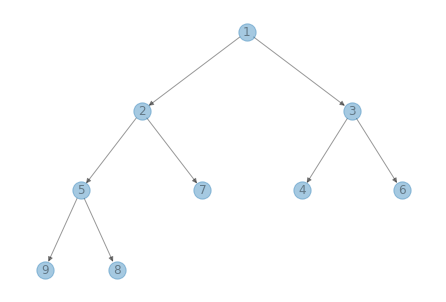

In [8]:
print(heap)
draw_heap(heap)

## The Heap Property

If the list is a heap, the tree should have the heap property: 

> Every parent is less than or equal to its children.

Or more formally:

> For all pairs of nodes P and C, where P is the parent of C, the value of P must be less than or equal to the value of C.

The following function checks whether this property is true for all nodes.

In [9]:
def is_heap(heap):
    """Check if a sequence has the heap property.
    
    Every child should be >= its parent.
    """
    for i in range(1, len(heap)):
        parent = (i-1) // 2
        if heap[parent] > heap[i]:
            return False
    return True

As we might hope, `heap` is a heap.

In [10]:
is_heap(heap)

True

Here's a list of integers in no particular order, and as you might expect, it does not have the heap property.

In [11]:
data = [4, 9, 3, 7, 5, 1, 6, 8, 2]
is_heap(data)

False

## Using a Heap to Sort

Given a heap, we can implement a sort algorithm called [heapsort](https://en.wikipedia.org/wiki/Heapsort). 

Let's start again with a fresh heap:

In [12]:
heap = []
for x in data:
    heappush(heap, x)

If we know that a list is a heap, we can use `heappop` to find and remove the smallest element.

In [13]:
heappop(heap)

1

`heappop` rearranges the remaining elements of the list to restore the heap property (we'll see how soon). 

In [14]:
heap

[2, 5, 3, 8, 7, 4, 6, 9]

In [15]:
is_heap(heap)

True

And that means we can use `heappop` again to get the second smallest element (of the original heap):

In [16]:
heappop(heap)

2

Which means we can use a heap to sort a list.

**Exercise:** Write a generator function called `heapsort` that takes an iterable and yields the elements of the iterable in increasing order. 

In [17]:
# Solution

def heapsort(t):
    heap = []
    for x in t:
        heappush(heap, x)
    while heap:
        yield heappop(heap)

In [18]:
# Solution

list(heapsort(data))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [19]:
# Solution

from heapq import heapify

def heapsort(iterable):
    heap = [x for x in iterable]
    heapify(heap)
    while heap:
        yield heappop(heap)

In [20]:
# Solution

list(heapsort(data))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

Now let's see how a heap is implemented.
The two key methods are `push` and `pop`.

## Push

To insert an element in a heap, you start by appending it to the list.

The result is generally not a heap, so you have to do some work to restore the heap property:

* If the new element is greater than or equal to its parent, you are done.

* Otherwise swap the new element with its parent.

* If the new element is greater than or equal to the parent's parent, you are done.

* Otherwise swap the new element with its parent's parent.

* And repeat, working your way up the tree, until you're done or you reach the root.

This process is called "sift-up" or sometimes [swim](https://en.wikipedia.org/wiki/Heap_(data_structure)#Implementation).

**Exercise:** Write a function called `push` that does the same thing as `heappush`: it should take as parameters a list (which should be a heap) and a new element; it should add the new element to the list and restore the heap property.

In [21]:
# Solution

def swap(heap, i, j):
    heap[j], heap[i] = heap[i], heap[j]

def push(heap, x):
    heap.append(x)
    i = len(heap) - 1
    while i > 0:
        parent = (i-1)//2
        if heap[parent] <= heap[i]:
            break
        swap(heap, i, parent)
        i = parent

You can use this example to test your code:

In [22]:
heap = []
for x in data:
    push(heap, x)
    assert is_heap(heap)

heap

[1, 2, 3, 5, 7, 4, 6, 9, 8]

In [23]:
is_heap(heap)

True

## Pop

To remove an element from the heap, you:

* Make a copy of the root element,

* Pop the *last* element off the list and store it at the root.

* Then you have to restore the heap property. If the new root is less than or equal to both of its children, you are done.

* Otherwise, swap the parent with the smaller of its children.

* Then repeat the process with the child you just replaced, and continue until you get to a leaf node.

This process is called a "sift-down" or sometimes "sink".

**Exercise:** Write a function called `pop` that does the same thing as `heappop`: it should remove the smallest element, restore the heap property, and return the smallest element.

Hint: This one is tricky because you have to deal with several special cases.

In [28]:
# Solution

def pop(heap):
    smallest = heap[0]
    final = heap.pop()
    if len(heap) == 0:
        return smallest
    
    heap[0] = final
    i = 0
    last = len(heap)-1
    
    while True:
        left, right = 2*i + 1, 2*i + 2

        if left > last:
            # print('leaf')
            return smallest
        
        if right > last:
            # print('no right child')
            right = left
            
        if heap[i] <= min(heap[left], heap[right]):
            # print('heap property restored')
            return smallest
        elif heap[left] < heap[right]:
            # print('left child is smaller')
            winner = left
        else:
            # print('right child is smaller')
            winner = right
        
        swap(heap, i, winner)
        i = winner

In [29]:
heap = []
for x in data:
    heappush(heap, x)

while heap:
    print(pop(heap))
    assert is_heap(heap)

1
2
3
4
5
6
7
8
9


In [30]:
# Solution

# From https://github.com/python/cpython/blob/3.10/Lib/heapq.py

def heappush(heap, item):
    """Push item onto heap, maintaining the heap invariant."""
    heap.append(item)
    _siftdown(heap, 0, len(heap)-1)

def heappop(heap):
    """Pop the smallest item off the heap, maintaining the heap invariant."""
    lastelt = heap.pop()    # raises appropriate IndexError if heap is empty
    if heap:
        returnitem = heap[0]
        heap[0] = lastelt
        _siftup(heap, 0)
        return returnitem
    return lastelt

def _siftdown(heap, startpos, pos):
    newitem = heap[pos]
    # Follow the path to the root, moving parents down until finding a place
    # newitem fits.
    while pos > startpos:
        parentpos = (pos - 1) >> 1
        parent = heap[parentpos]
        if newitem < parent:
            heap[pos] = parent
            pos = parentpos
            continue
        break
    heap[pos] = newitem
    
def _siftup(heap, pos):
    endpos = len(heap)
    startpos = pos
    newitem = heap[pos]
    # Bubble up the smaller child until hitting a leaf.
    childpos = 2*pos + 1    # leftmost child position
    while childpos < endpos:
        # Set childpos to index of smaller child.
        rightpos = childpos + 1
        if rightpos < endpos and not heap[childpos] < heap[rightpos]:
            childpos = rightpos
        # Move the smaller child up.
        heap[pos] = heap[childpos]
        pos = childpos
        childpos = 2*pos + 1
    # The leaf at pos is empty now.  Put newitem there, and bubble it up
    # to its final resting place (by sifting its parents down).
    heap[pos] = newitem
    _siftdown(heap, startpos, pos)

In [31]:
# Solution

heap = []
for x in data:
    heappush(heap, x)

while heap:
    print(heappop(heap))
    assert is_heap(heap)

1
2
3
4
5
6
7
8
9


*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)